## Title: World Cup Prediction with Logistic Regression
-----------------------------------------------------------------------------------------------

## Data Exploration

In [28]:
# import necessary modules

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from PIL import Image
import IPython.display as display
import warnings
warnings.filterwarnings("ignore")



In [29]:
# import FIFA Ranking Data

rankings = pd.read_csv('fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

rankings.head(10)

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1,Germany,GER,0.0,1993-08-08,0.0,0.0,0.0
1,2,Italy,ITA,0.0,1993-08-08,0.0,0.0,0.0
2,3,Switzerland,SUI,0.0,1993-08-08,0.0,0.0,0.0
3,4,Sweden,SWE,0.0,1993-08-08,0.0,0.0,0.0
4,5,Argentina,ARG,0.0,1993-08-08,0.0,0.0,0.0
5,6,Republic of Ireland,IRL,0.0,1993-08-08,0.0,0.0,0.0
6,7,Russia,RUS,0.0,1993-08-08,0.0,0.0,0.0
7,8,Brazil,BRA,0.0,1993-08-08,0.0,0.0,0.0
8,9,Norway,NOR,0.0,1993-08-08,0.0,0.0,0.0
9,10,Denmark,DEN,0.0,1993-08-08,0.0,0.0,0.0


In [30]:
# Import past fixtures between teams from 1872 to 2018 
matches = pd.read_csv('results.csv')
#matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

matches.head(15)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
5,1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,False
7,1877-03-05,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False
8,1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False
9,1878-03-23,Scotland,Wales,9,0,Friendly,Glasgow,Scotland,False


In [31]:
# import World Cup 2022 fixtures
world_cup = pd.read_csv('World Cup 2022 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group','Previous \ntitles','Previous \nappearances','First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.set_index('Team')

world_cup.head()

,Group,Previous \ntitles,Previous \nappearances,First match \nagainst,Second match\n against,Third match\n against
Team,,,,,,
Qatar,A,0,0,Ecuador,Senegal,Netherlands
Ecuador,A,0,3,Qatar,Netherlands,Senegl
Netherlands,A,0,10,Senegal,Ecuador,Qatar
Senegal,A,0,2,Netherlands,Qatar,Ecuador
USA,B,0,10,China PR,England,Iran


## Feature Extraction

In [32]:
# Obtain the complete Date-wise ranking table 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranking with matches
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0.0,0.0,1993-08-08,22.0,Uruguay,URU,0.0,0.0,0.0,0.0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,...,0.0,0.0,1993-08-08,14.0,Mexico,MEX,0.0,0.0,0.0,0.0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,...,0.0,0.0,1993-08-08,94.0,Venezuela,VEN,0.0,0.0,0.0,0.0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,...,0.0,0.0,1993-08-08,86.0,Sierra Leone,SLE,0.0,0.0,0.0,0.0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,...,0.0,0.0,1993-08-08,5.0,Argentina,ARG,0.0,0.0,0.0,0.0


<AxesSubplot:>

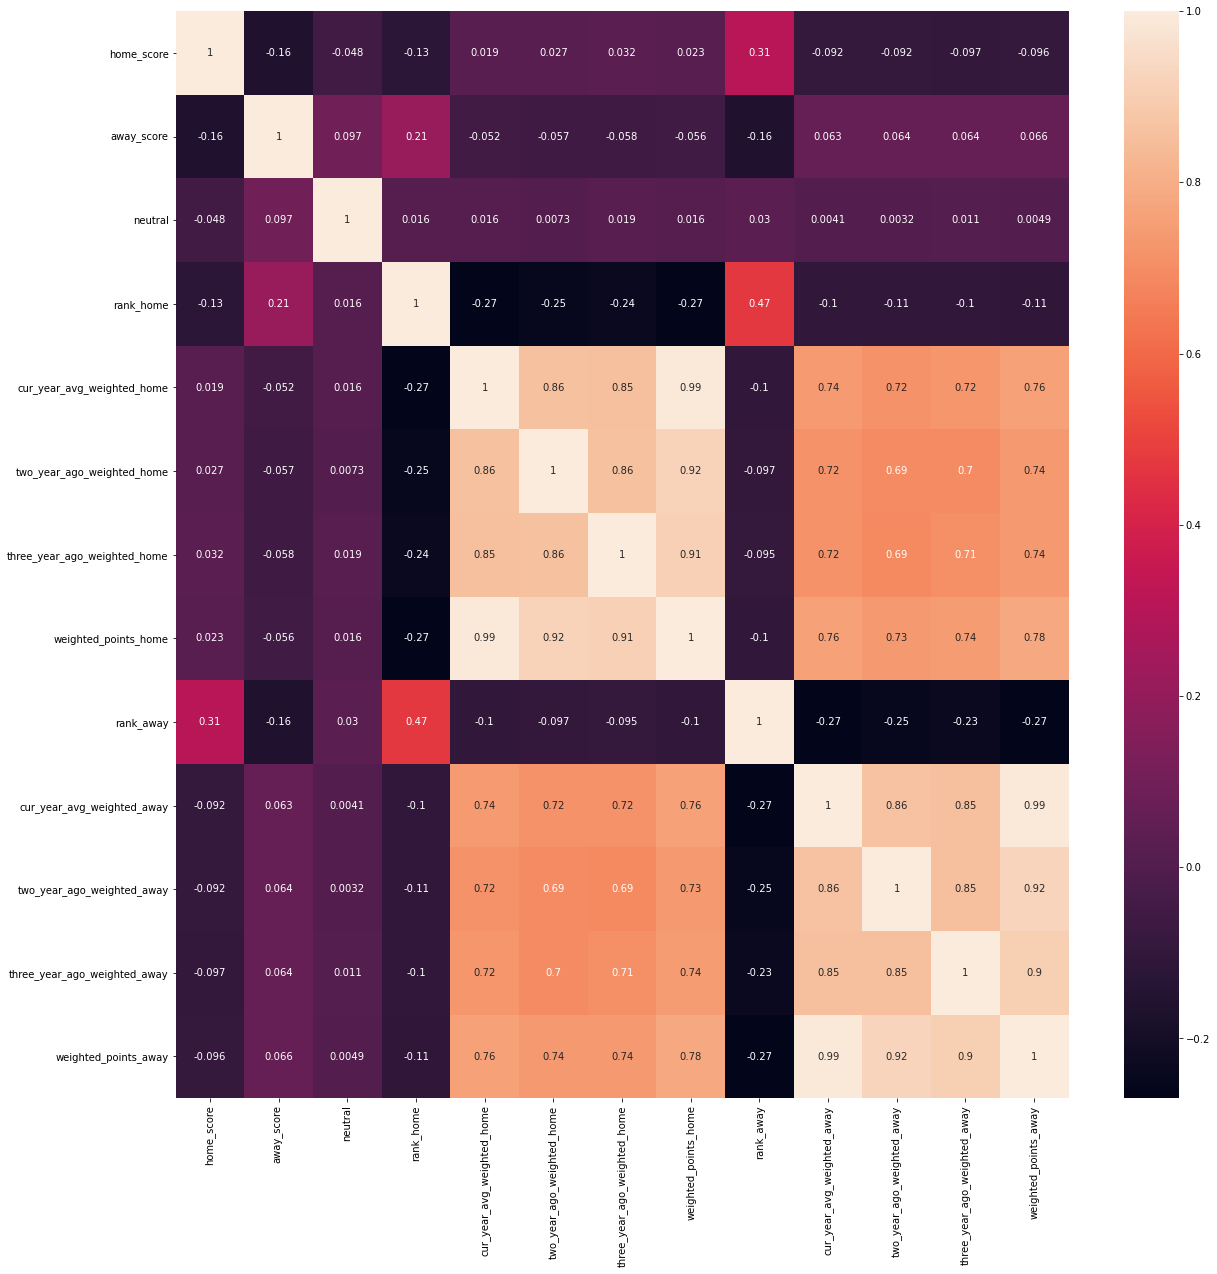

In [33]:
# Finding correlation for columns

import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
corr1 = matches.corr()
corr1
sns.heatmap(corr1,annot=True)

In [34]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

## Data modelling

In [35]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures



X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5, max_iter=2000)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)



## Performance Evaluation

Logistic Regression accuracy is : 0.6761555806087937
aqui: 3548
              precision    recall  f1-score   support

       False       0.68      0.70      0.69      1809
        True       0.68      0.65      0.66      1739

    accuracy                           0.68      3548
   macro avg       0.68      0.68      0.68      3548
weighted avg       0.68      0.68      0.68      3548



<AxesSubplot:>

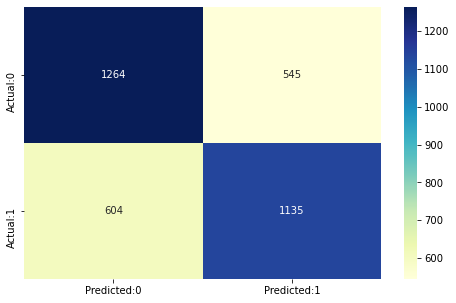

In [36]:
# Performance Evaluation: Accuracy and Confusion Matrix

mod_accuracy = model.score(X_test,y_test)
print("Logistic Regression accuracy is :",mod_accuracy)

lr_pred= model.predict(X_test)
print("aqui:",len(lr_pred))

report = classification_report(y_test,lr_pred)
print(report)

cm = confusion_matrix(y_test, model.predict(X_test))
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

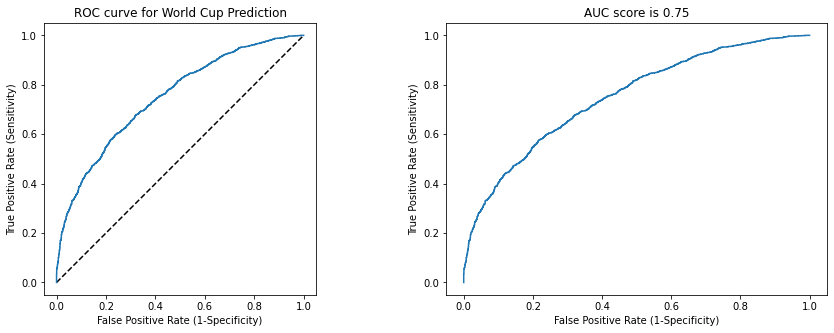

In [37]:
# Performance evaluation: ROC and AUC


fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('ROC curve for World Cup Prediction')
ax.set_xlabel('False Positive Rate (1-Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_aspect(1)


ax = plt.subplot(1,2,2)
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_xlabel('False Positive Rate (1-Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')

pass

Stakes distribution in the wrong predictions
True     0.547433
False    0.452567
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.621308
False    0.378692
Name: is_stake, dtype: float64


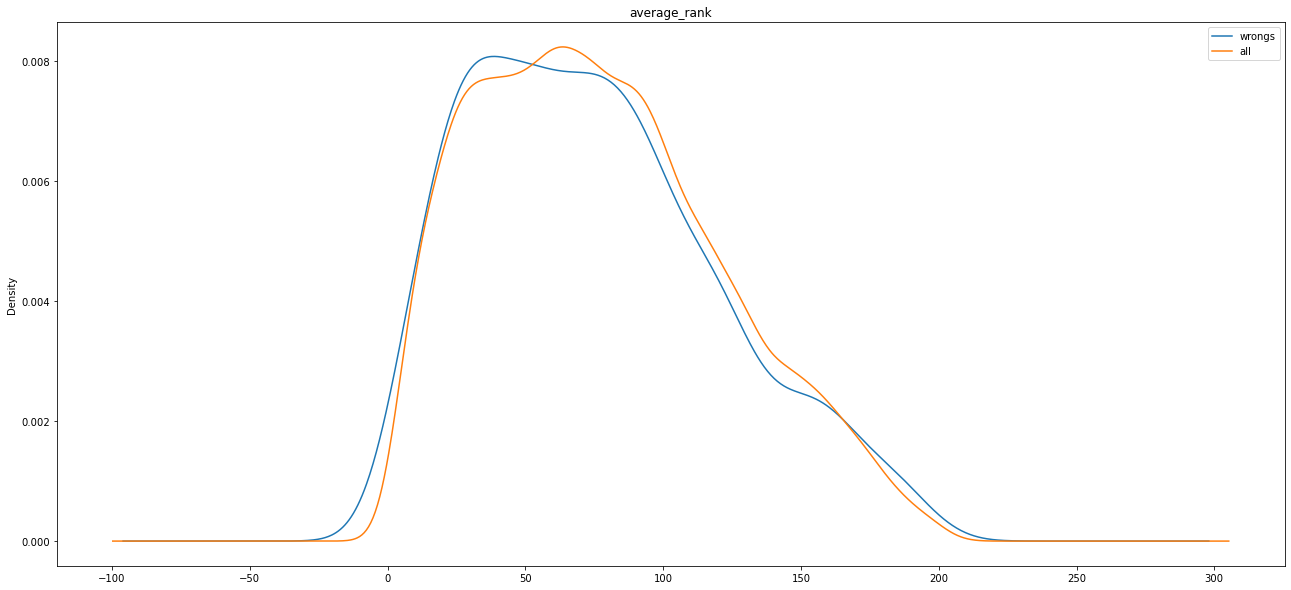

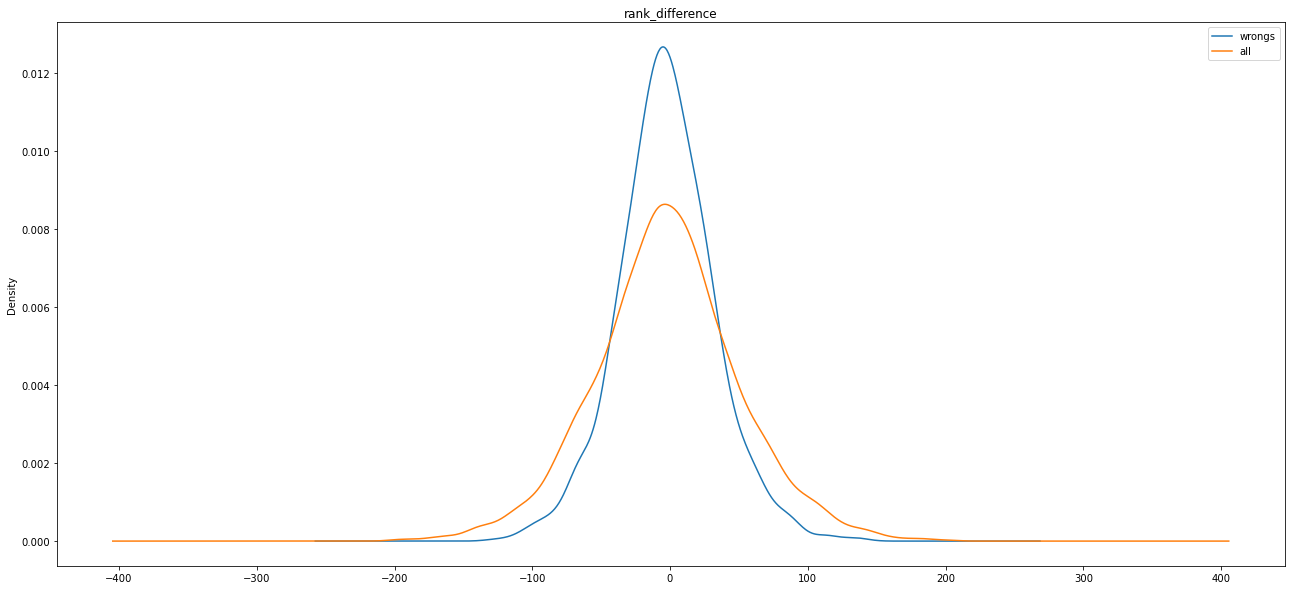

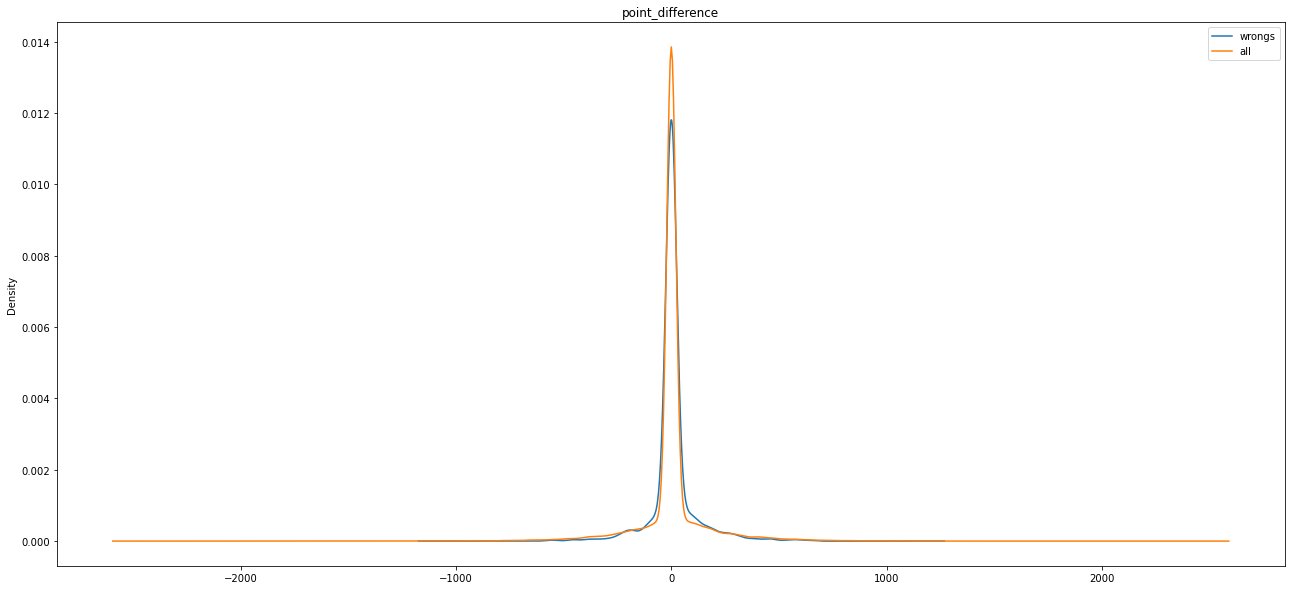

In [38]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

In [39]:
def outputs(timer):
    time.sleep(timer)
    print("Calculando")
    time.sleep(timer)
    print("--------------------"+"0%")
    time.sleep(timer)
    print("*****---------------"+"25%")
    time.sleep(timer)
    print("**********----------"+"50%")
    time.sleep(timer)
    print("***************-----"+"75%")
    time.sleep(timer)
    print("********************"+"100%")
    time.sleep(timer)

In [40]:
def competir(home,away):
    if home=="Usa" :
        home = "USA"
    if away =="Usa":
        away = "USA"

    try:
        row2 = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        timer = int(2)
        print("{} vs. {}: ".format(home, away), end='')
        #versus(home,away)
        #versus_img = Image.open("versus-temporal.png")
        #display.display(versus_img.resize((400,200)))
        home_png = Image.open("flags/"+home+".png")
        away_png = Image.open("flags/"+away+".png")
        time.sleep(timer-1)
        display.display(home_png.resize((400,200)))
        print("-----------------------Vs-----------------------")
        display.display(away_png.resize((400,200)))
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row2['average_rank'] = (home_rank + opp_rank) / 2
        row2['rank_difference'] = home_rank - opp_rank
        row2['point_difference'] = home_points - opp_points
        #print(row2)
        home_win_prob = model.predict_proba(row2)[:,1][0]
        points = 0
        if home_win_prob <= 0.5 - margin:
            outputs(2)
            print("{} gana con {:.2f} de probabilidad".format(away, 1-home_win_prob))
            #print(away)
            ganador = Image.open("flags/"+away+".png")
            display.display(ganador.resize((400,200)))
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            outputs(2)
            print("{} gana con {:.2f} de probabilidad".format(home, home_win_prob))
            #print(home)
            ganador = Image.open("flags/"+home+".png")
            display.display(ganador.resize((400,200)))
        if points == 1:
            outputs(2)
            print("Empate")
            empate = Image.open("Empate.jpeg")
            display.display(empate.resize((400,200)))
    except:
          print(" Equipo no existe: Vuelva a ingresar los datos!!!!")

In [42]:
def versus(home,away):
    # library
      
# opening up of images
    img = Image.open("flags/"+home+".png")
    img1 = Image.open("flags/"+away+".png")
    img.size
    img1.size
    img_size = img.resize((425, 380))
    img1_size = img1.resize((425, 380))
  
    # creating a new image and pasting 
    # the images
    img2 = Image.new("RGB", (900, 400), "gray")
  
    # pasting the first image (image_name,
    # (position))
    img2.paste(img_size, (15, 15))
  
    # pasting the second image (image_name,
    # (position))
    img2.paste(img1_size, (460, 15))
    plt.rcParams["figure.figsize"] = (22, 10)
    plt.imshow(img2)
    plt.axis('off')
    plt.savefig("versus-temporal.png",)

#versus("Argentina", "Brazil")


In [43]:
def versus_finals(eq1,eq2,eq3,eq4):
    # library
      
# opening up of images
    img = Image.open("flags/"+eq1+".png")
    img1 = Image.open("flags/"+eq2+".png")
    img3 = Image.open("flags/"+eq3+".png")
    img4 = Image.open("flags/"+eq4+".png")
    img.size
    img1.size
    img_size = img.resize((425, 380))
    img1_size = img1.resize((425, 380))
    img3_size = img3.resize((425, 380))
    img4_size = img4.resize((425, 380))
  
    # creating a new image and pasting 
    # the images
    img2 = Image.new("RGB", (1800, 400), "gray")
  
    # pasting the first image (image_name,
    # (position))
    img2.paste(img_size, (15, 15))
  
    # pasting the second image (image_name,
    # (position))
    img2.paste(img1_size, (460, 15))
    plt.rcParams["figure.figsize"] = (22, 10)
    
    # pasting the third image (image_name,
    # (position))
    img2.paste(img3_size, (910, 15))
    plt.rcParams["figure.figsize"] = (22, 10)
    
    # pasting the third image (image_name,
    # (position))
    img2.paste(img4_size, (1360, 15))
    plt.rcParams["figure.figsize"] = (22, 10)
    
    
    plt.imshow(img2)
    plt.axis('off')
    plt.savefig("versus-temporal.png",)

#versus_finals("Argentina", "Brazil","USA", "Croatia")

## World cup simulations

### Group Stages

In [45]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])


In [47]:
# Looping through groups to predict winners based on the trained model

from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        #home= home
        #away= "England"
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        #print("aqui2-home-win-prob",home_win_prob)
        print("aqui2-fila",home,away)

        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1
            
#world_cup

___Starting group A:___
Qatar vs. Ecuador: aqui2-fila Qatar Ecuador
Ecuador wins with 0.72
Qatar vs. Netherlands: aqui2-fila Qatar Netherlands
Netherlands wins with 0.88
Qatar vs. Senegal: aqui2-fila Qatar Senegal
Senegal wins with 0.84
Ecuador vs. Netherlands: aqui2-fila Ecuador Netherlands
Netherlands wins with 0.76
Ecuador vs. Senegal: aqui2-fila Ecuador Senegal
Senegal wins with 0.70
Netherlands vs. Senegal: aqui2-fila Netherlands Senegal
Draw
___Starting group D:___
France vs. Italy: aqui2-fila France Italy
France wins with 0.56
France vs. Denmark: aqui2-fila France Denmark
Draw
France vs. Tunisia: aqui2-fila France Tunisia
France wins with 0.56
Italy vs. Denmark: aqui2-fila Italy Denmark
Denmark wins with 0.59
Italy vs. Tunisia: aqui2-fila Italy Tunisia
Draw
Denmark vs. Tunisia: aqui2-fila Denmark Tunisia
Draw
___Starting group E:___
Spain vs. Nigeria: aqui2-fila Spain Nigeria
Spain wins with 0.64
Spain vs. Germany: aqui2-fila Spain Germany
Germany wins with 0.60
Spain vs. Japan:

Single - elimination rounds

In [48]:
world_cup

,Group,Previous \ntitles,Previous \nappearances,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,,,
Qatar,A,0,0,Ecuador,Senegal,Netherlands,0,0.562358
Ecuador,A,0,3,Qatar,Netherlands,Senegl,3,1.257906
Netherlands,A,0,10,Senegal,Ecuador,Qatar,7,2.178082
Senegal,A,0,2,Netherlands,Qatar,Ecuador,7,2.001654
USA,B,0,10,China PR,England,Iran,4,1.624409
Iran,B,0,5,England,China PR,USA,4,1.443469
China PR,B,0,1,USA,Iran,England,0,0.841439
England,B,1,15,Iran,USA,China PR,9,2.090682
Saudi Arabia,C,0,5,Argentina,Poland,Mexico,0,0.551320


### Elimination Stages

In [49]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]
world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
#next_round_wc = next_round_wc.set_index('Team')
teams = next_round_wc["Team"]
teams = list(teams)
equipos = []
for i in teams:
    if i in equipos:
        pass
    else:
        equipos.append(i)

## ¿Qué equipos pasarón la fase de grupos?

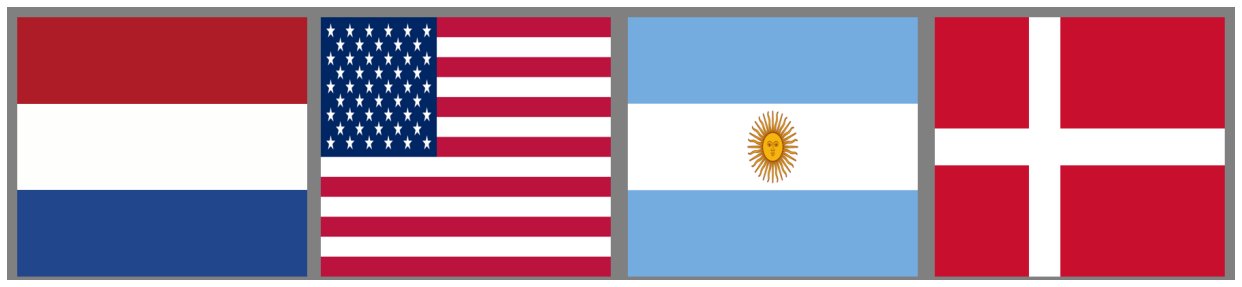

In [50]:
versus_finals(equipos[0],equipos[1],equipos[2],equipos[3])

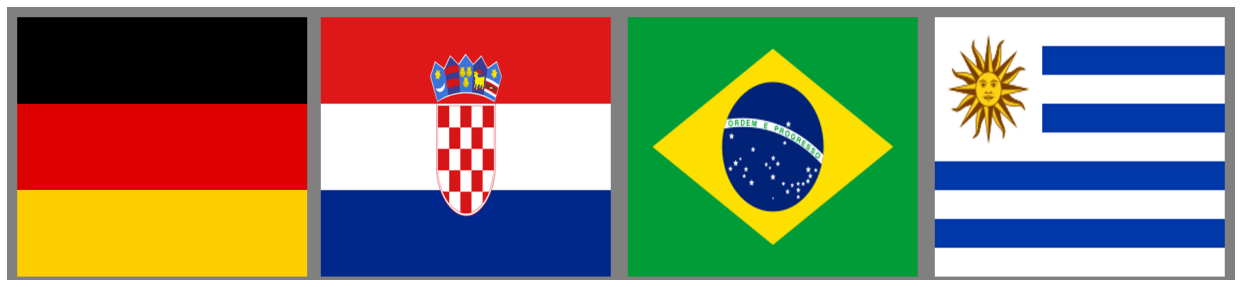

In [51]:
versus_finals(equipos[4],equipos[5],equipos[6],equipos[7])

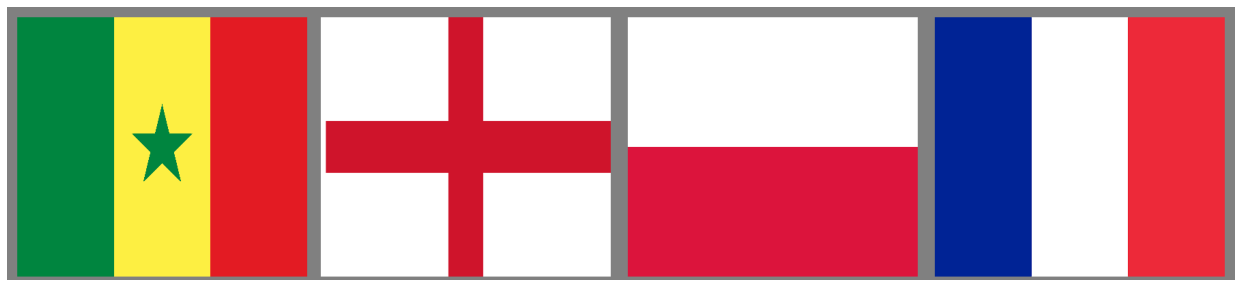

In [52]:
versus_finals(equipos[8],equipos[9],equipos[10],equipos[11])

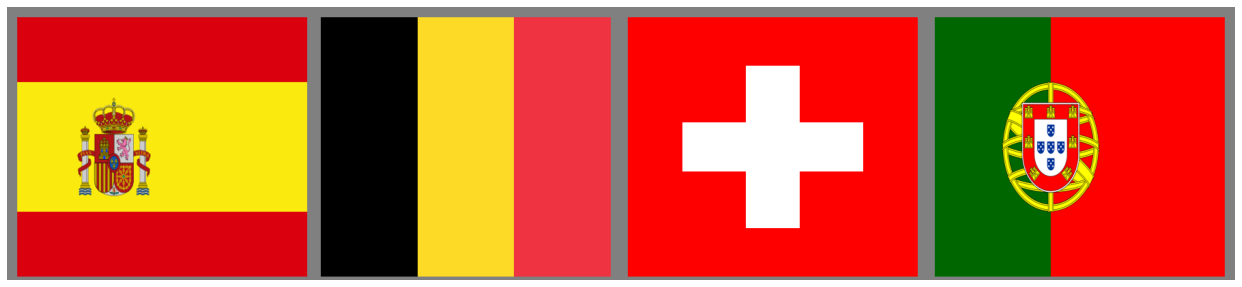

In [53]:
versus_finals(equipos[12],equipos[13],equipos[14],equipos[15])

___Starting of the round_of_16___
Netherlands vs. USA: 

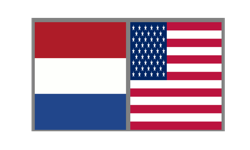

Netherlands wins with probability 0.53


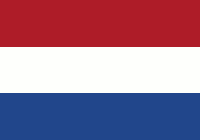

------------------------------------------------------------
Argentina vs. Denmark: 

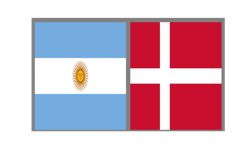

Argentina wins with probability 0.52


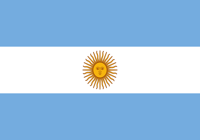

------------------------------------------------------------
Germany vs. Croatia: 

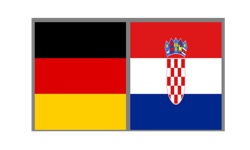

Germany wins with probability 0.60


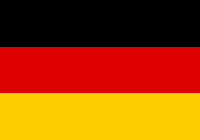

------------------------------------------------------------
Brazil vs. Uruguay: 

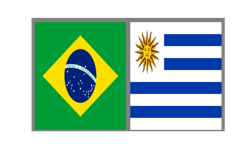

Brazil wins with probability 0.56


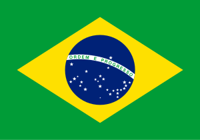

------------------------------------------------------------
Senegal vs. England: 

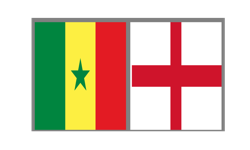

England wins with probability 0.61


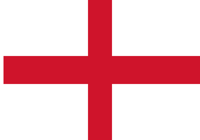

------------------------------------------------------------
Poland vs. France: 

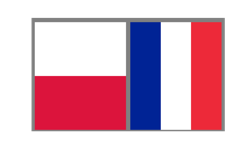

France wins with probability 0.52


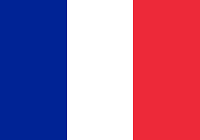

------------------------------------------------------------
Spain vs. Belgium: 

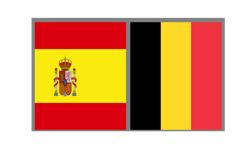

Belgium wins with probability 0.56


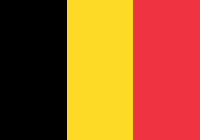

------------------------------------------------------------
Switzerland vs. Portugal: 

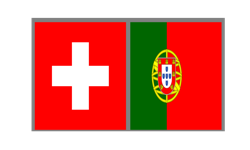

Portugal wins with probability 0.53


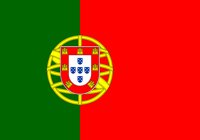

------------------------------------------------------------
------------NEXT ROUND------------


___Starting of the quarterfinal___
Netherlands vs. Argentina: 

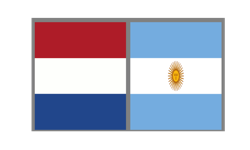

Argentina wins with probability 0.57


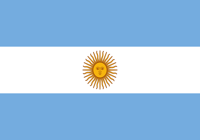

------------------------------------------------------------
Germany vs. Brazil: 

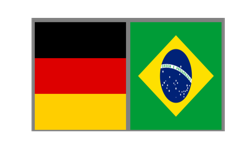

Germany wins with probability 0.53


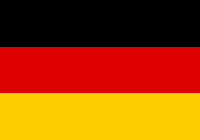

------------------------------------------------------------
England vs. France: 

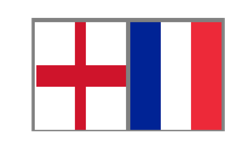

France wins with probability 0.54


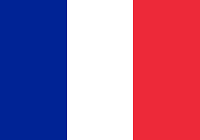

------------------------------------------------------------
Belgium vs. Portugal: 

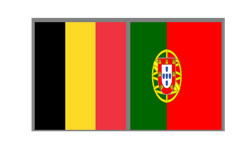

Belgium wins with probability 0.51


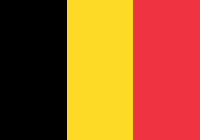

------------------------------------------------------------
------------NEXT ROUND------------


___Starting of the semifinal___
Argentina vs. Germany: 

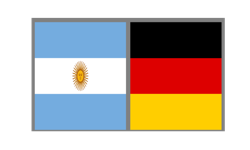

Germany wins with probability 0.57


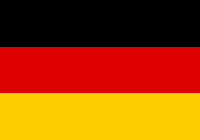

------------------------------------------------------------
France vs. Belgium: 

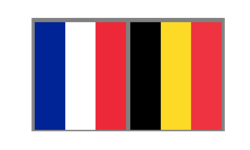

Belgium wins with probability 0.56


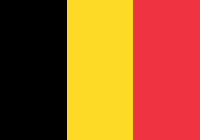

------------------------------------------------------------
------------NEXT ROUND------------


___Starting of the final___
Germany vs. Belgium: 

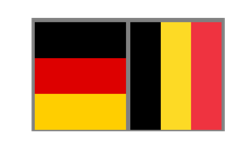

Germany wins with probability 0.53


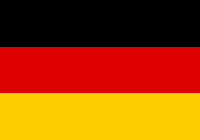

------------------------------------------------------------
------------NEXT ROUND------------




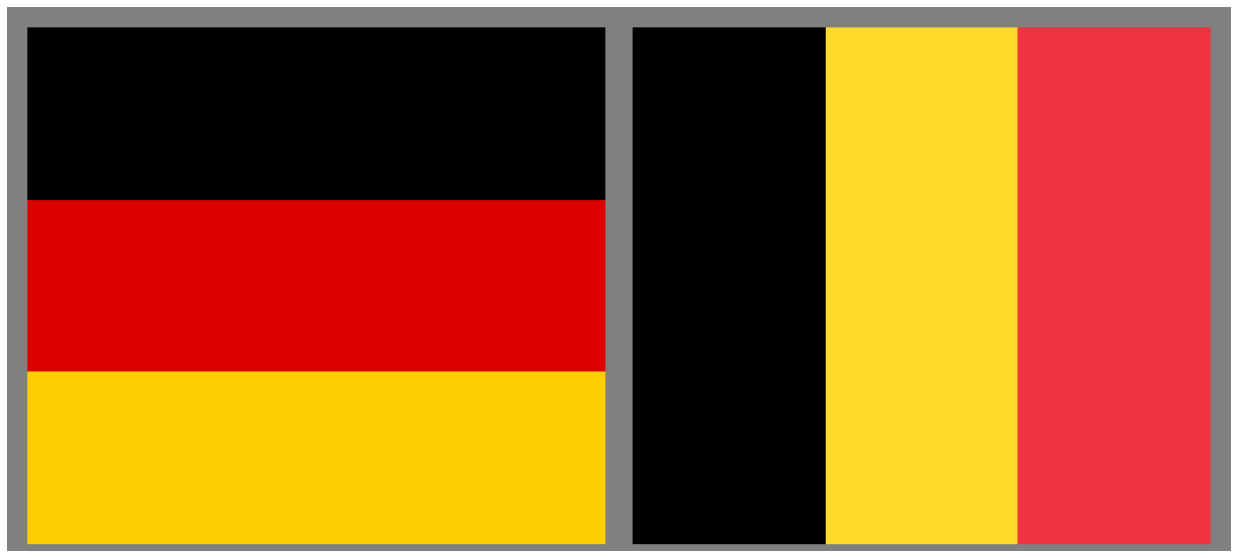

In [54]:
# Single Elimation Stage Rounds

pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        versus(home,away)
        versus_img = Image.open("versus-temporal.png") 
        display.display(versus_img.resize((250,150)))
        
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
            ganador = Image.open("flags/"+away+".png")
            display.display(ganador.resize((200,140)))
            print("------------------------------------------------------------")
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)
            ganador = Image.open("flags/"+home+".png")
            display.display(ganador.resize((200,140)))
            print("------------------------------------------------------------")
            
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
        time.sleep(3) 
    
    time.sleep(5) 
    print("------------NEXT ROUND------------")
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

def competir(home,away):
    row2 = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
    print("{} vs. {}: ".format(home, away), end='')
    home_rank = world_cup_rankings.loc[home, 'rank']
    home_points = world_cup_rankings.loc[home, 'weighted_points']
    opp_rank = world_cup_rankings.loc[away, 'rank']
    opp_points = world_cup_rankings.loc[away, 'weighted_points']
    row2['average_rank'] = (home_rank + opp_rank) / 2
    row2['rank_difference'] = home_rank - opp_rank
    row2['point_difference'] = home_points - opp_points
    #print(row2)
    home_win_prob = model.predict_proba(row2)[:,1][0]
    points = 0
    if home_win_prob <= 0.5 - margin:
        print("{} gana con {:.2f}".format(away, 1-home_win_prob))
        print(away)
        time.sleep(5)
    if home_win_prob > 0.5 - margin:
        points = 1
    if home_win_prob >= 0.5 + margin:
        points = 3
        time.sleep(5)
        print("{} gana con {:.2f}".format(home, home_win_prob))
        print(home)
    if points == 1:
        time.sleep(5)
        print("Empate")
    print("--------------------------------")

equipos = len(world_cup_rankings.index)
equipo1,equipo2 =  0,1
continuar="s"
import time
import IPython.display as display
from PIL import Image
equipos_grupos=Image.open('equipos-grupos.png')
#print(imagen.size)
#display.display(imagen.resize((989,379)))
#display.display(equipos_grupos)
for i in range(equipos):
  print(i,":",world_cup_rankings.index[i])
while continuar =="s":
    display.display(equipos_grupos)
    time.sleep(1)
    equipo1 = input('Ingresea el nombre del equipo1: ').title()
    equipo2 = input('Ingresea el nombre del equipo2: ').title()
    competir(equipo1, equipo2)
    continuar=input("Continuar 'Si = s': ")

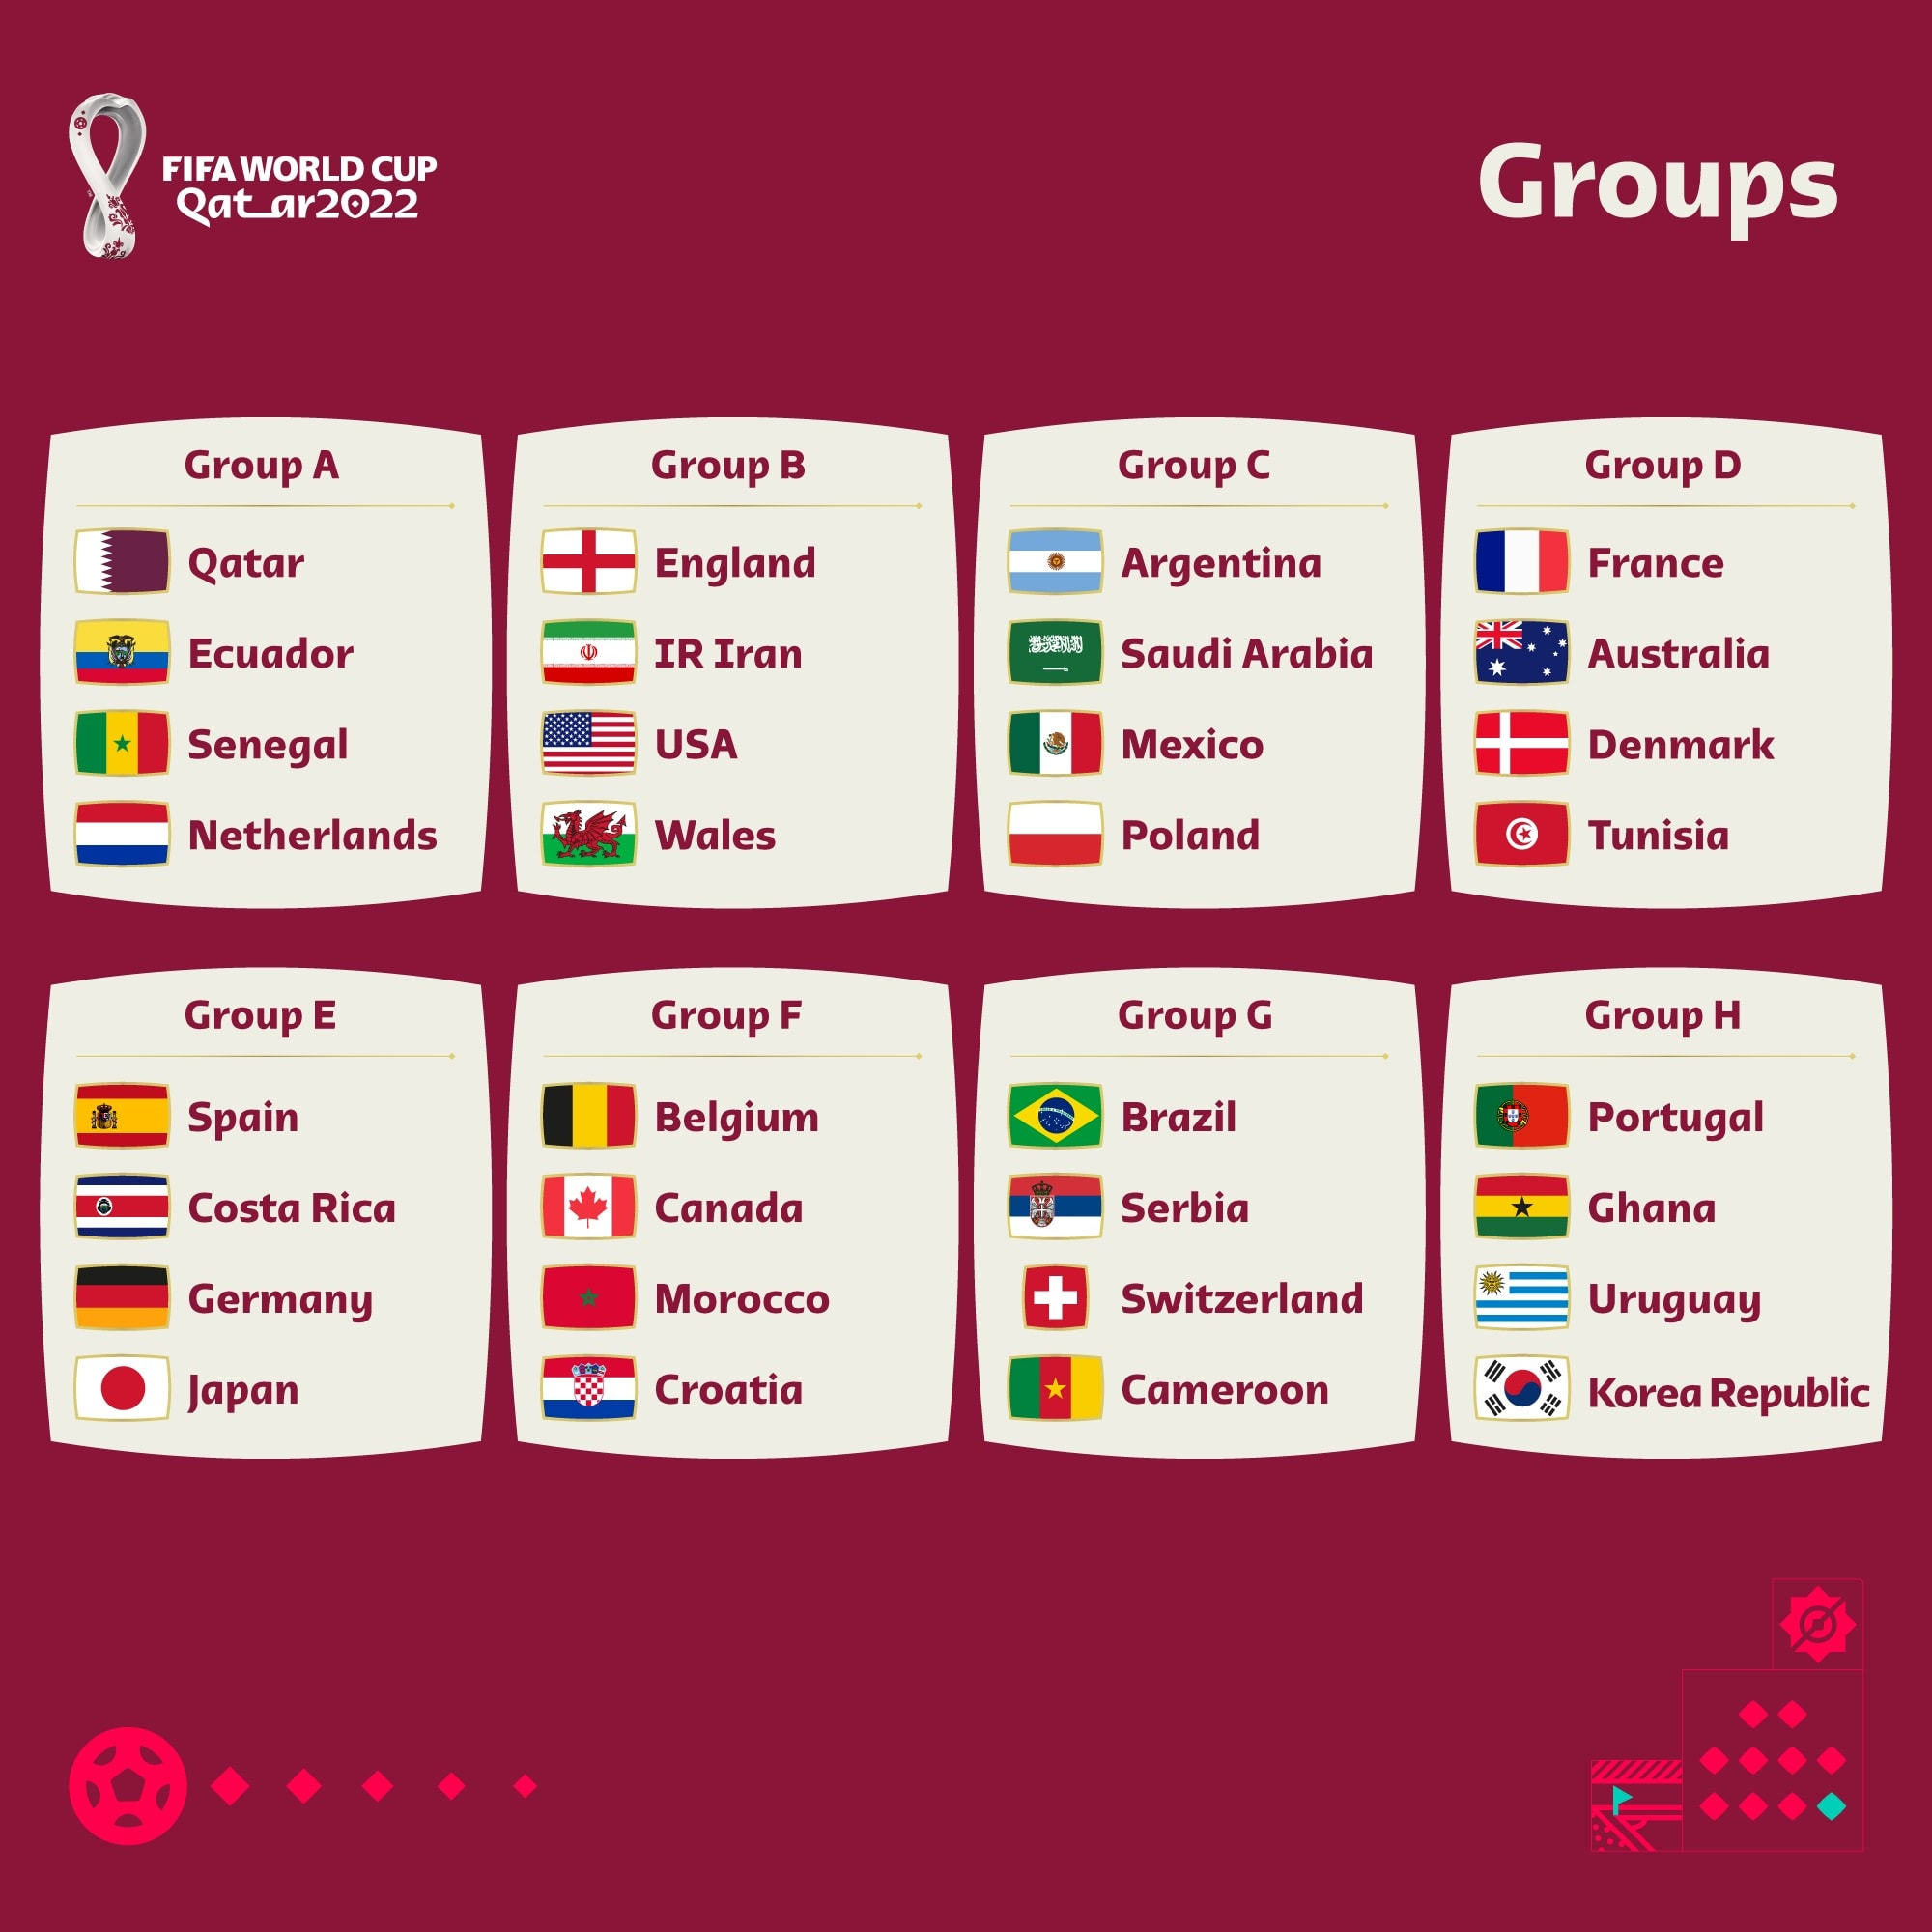

In [55]:
import IPython.display as display
from PIL import Image
equipos_grupos=Image.open("FIFA-World-Cup-Qatar-2022-Final-groups.jpg",)
#print(imagen.size)
#display.display(imagen.resize((989,379)))
display.display(equipos_grupos)

Ingrese el numero del equipo 1: 2
Ingrese el numero del equipo 2: 32
Belgium vs. Uruguay: 

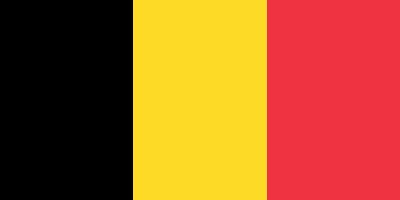

-----------------------Vs-----------------------


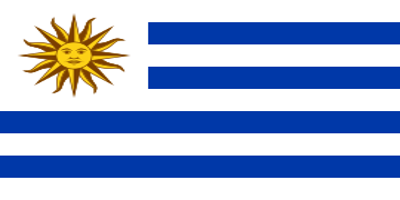

Calculando
--------------------0%
*****---------------25%
**********----------50%
***************-----75%
********************100%
Belgium gana con 0.56 de probabilidad


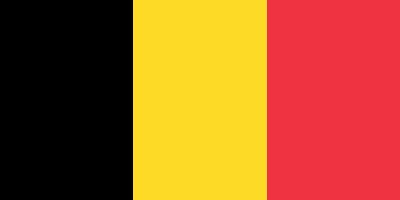

In [56]:
equipos = len(world_cup_rankings.index)
equipo1,equipo2 =  0,1
continuar="s"
import time
import IPython.display as display
from PIL import Image
equipos_grupos=Image.open('FIFA-World-Cup-Qatar-2022-Final-groups.jpg')

#for i in range(equipos):
#    print(i+1,":",world_cup_rankings.index[i])
    
numero1  = int(input('Ingrese el numero del equipo 1: '))
equipo1=world_cup_rankings.index[numero1-1]
numero2  = int(input('Ingrese el numero del equipo 2: '))
equipo2=world_cup_rankings.index[numero2-1]

time.sleep(1)
competir(equipo1, equipo2)